<a href="https://colab.research.google.com/github/Yaffa16/-rpi_posenet/blob/master/GAN_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/justinpinkney/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 35.41 MiB/s, done.
Resolving deltas: 100% (141/141), done.


## Load tensorflow and other boring stuff

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2")

In [ ]:
%tensorflow_version 1.x

import numpy as np
import PIL.Image, pickle, re, sys, time, cv2, librosa

import dnnlib
import dnnlib.tflib as tflib
import tensorflow as tf
import matplotlib.pyplot as plt

import pretrained_networks
import projector

from align_images import *
landmarks_model_path = unpack_bz2(get_file('shape_predictor_68_face_landmarks.dat.bz2', LANDMARKS_MODEL_URL, cache_subdir='temp'))
landmarks_detector = LandmarksDetector(landmarks_model_path)

TensorFlow 1.x selected.
64045056/64040097 [==============================] - 3s 0us/step


In [ ]:

def preprocess(proj_img):
  proj_img = adjust_dynamic_range(proj_img)
  proj_img = np.asarray(proj_img, dtype=np.float)
  proj_img = proj_img.transpose(2,0,1)
  proj_img = np.expand_dims(proj_img, axis=0)
  return proj_img[:,:3,:,:]
  
def adjust_dynamic_range(data, drange_in=[0,255], drange_out=[-1,1]):
    if drange_in != drange_out:
        scale = (np.float32(drange_out[1]) - np.float32(drange_out[0])) / (np.float32(drange_in[1]) - np.float32(drange_in[0]))
        bias = (np.float32(drange_out[0]) - np.float32(drange_in[0]) * scale)
        data = data * scale + bias
    return data

def generate_images(lat, Gs):
  batch = 20
  out_imgs = []
  for e in range(lat.shape[0])[::batch]:
    lat_batch = lat[e:e+batch]
    out = Gs.components.synthesis.run(lat_batch, **Gs_kwargs)
    for o in out:
      out_imgs.append(o)
  return np.asarray(out_imgs)

def show_images(images, size=256):
  return PIL.Image.fromarray(np.concatenate([o for o in images],axis=1)).resize((size*images.shape[0],size))

def save_images(images, filename):
  for i,o in enumerate(images):
    cv2.imwrite(filename%i,o[:, :, ::-1])#,[cv2.IMWRITE_JPEG_QUALITY, 100])

def Z2W(latent, Gs, psi=0.7, cut=10):
  dlatent_avg = Gs.get_var('dlatent_avg')
  latent = Gs.components.mapping.run(latent, None)
  latent[:,:cut] = (latent[:,:cut]-dlatent_avg)*psi + dlatent_avg
  return latent

def latent_walk(seed , num_frames=10):
  dif = seed[1:]-seed[:-1]
  # dif/=num_frames
  timeline = np.linspace(0,1,num_frames+1)[:-1]
  walk = np.array(np.zeros_like(dif[0]), ndmin=2)
  for i in range(dif.shape[0]):
    w = seed[i] + timeline[:,None]*dif[i]
    walk = np.concatenate([walk,w], axis=0)
  return walk[1:]

def blur(a, k_size=3):
    
  kernel = np.linspace(0,1,k_size)[1:]
  kernel = np.concatenate([kernel[:-1],kernel[::-1]])
  kernel = kernel / kernel.sum()
  arraylist = []
  for x in range(kernel.size):
      temparray_X = np.copy(a.T)
      temparray_X = np.roll(temparray_X, x - 1, axis=1)*kernel[x]
      arraylist.append(temparray_X)

  arraylist = np.array(arraylist)
  arraylist_sum = np.sum(arraylist, axis=0)
  return arraylist_sum.T

def interpolate_direction(lat, direction, scale = 5,  steps = 5, cut = 8):
  ver = np.linspace(-scale, scale, steps)
  lat_ver = []
  for v in ver:
    new_latent_vector = lat.copy()
    new_latent_vector[:,:cut] = ( lat + direction*v)[:,:cut]
    lat_ver.append(new_latent_vector)
  return np.concatenate(lat_ver)

def linear_interpolate(latent_code, direction, scale=5, steps=5):
  linspace = np.linspace(-scale, scale, steps)
  linspace = linspace.reshape(-1, 1, 1).astype(np.float32)
  linspace = linspace * direction
  return latent_code + linspace

from IPython.display import HTML
from base64 import b64encode

def video(path):
  mp4 = open(path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML('<video width=500 controls loop> <source src="%s" type="video/mp4"></video>' % data_url)

def list2numpy(latent_seq):
  convert_lat  = np.zeros_like(latent_seq[0])
  for i in latent_seq:
    convert_lat = np.concatenate([convert_lat,i], axis=0)
  return convert_lat[1:]

## Load pre-trained model

In [ ]:
network_name = "stylegan2-ffhq-config-f.pkl" #@param ["stylegan2-ffhq-config-f.pkl", "stylegan2-cat-config-f.pkl", "stylegan2-church-config-f.pkl", "stylegan2-car-config-f.pkl", "stylegan2-horse-config-f.pkl"]
network_pkl = "gdrive:networks/"+network_name
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
vector_size = Gs.input_shape[1:][0]
print ("Output shapes", Gs.output_shape)
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func= \
        tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
Gs_kwargs.truncation_psi = 1

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Output shapes [None, 3, 1024, 1024]


## Sound walk

In [ ]:
fps = 25

# aud_fn = "/content/Gunshot.mp3"
y, sr = librosa.load(aud_fn, duration=20)
D = librosa.feature.melspectrogram(y,sr,n_mels=512, hop_length=sr//fps)
# D/=D.max(axis=1)[:,None]

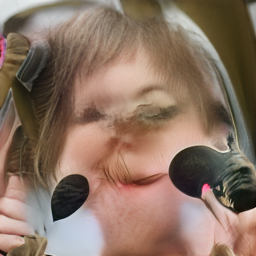

In [ ]:
psi = 2 #@param {type:"slider", min:0, max:10, step:0.01}
layers = 4 #@param {type:"slider", min:1, max:18, step:1}

seed = np.random.randn(1,vector_size)
dlatent = Z2W(seed, psi=psi, cut=layers, Gs=Gs)
out_img = generate_images(dlatent, Gs=Gs)
show_images(out_img)

In [ ]:
%%time
intensity = 4.6 #@param {type:"slider", min:0.5, max:50, step:0.1}
smooth = 4 #@param {type:"slider", min:1, max:10, step:1}
psi = 5 #@param {type:"slider", min:0, max:10, step:0.01}
layers = 4 #@param {type:"slider", min:1, max:18, step:1}
path = "out/"
!rm -r {path}
!mkdir {path}

sound_latent = adjust_dynamic_range(D, [D.min(), D.max(),], [0,intensity]).T
sound_latent = blur(sound_latent,smooth)
seeds = np.tile(seed, (sound_latent.shape[0],1))
seeds +=sound_latent
dlatent = Z2W(seeds, psi=psi, cut=layers, Gs=Gs)
out_img = generate_images(dlatent, Gs=Gs)
im_fn = path+"im%04d.jpg"
save_images(out_img,im_fn)

CPU times: user 28 s, sys: 8.58 s, total: 36.5 s
Wall time: 34.5 s


In [ ]:
fn = time.strftime('%d-%m-%H-%M-%S')
fn = "/content/"+fn
fn = "/tmp/tmp"
!ffmpeg -i {aud_fn} -r {fps} -f image2 -i {im_fn}  -c:v libx264 -c:a aac -shortest -pix_fmt yuv420p {fn}.mp4  -loglevel quiet -stats -y

frame=  501 fps=7.4 q=-1.0 Lsize=   14856kB time=00:00:20.06 bitrate=6066.1kbits/s speed=0.297x    


In [ ]:
video(fn+".mp4")

## Project image into latent space

In [ ]:
download_url = ""
!wget {download_url} -q

In [ ]:
img_path = ""
for i in landmarks_detector.get_landmarks(img_path):
  image_align(img_path,"/content/croped.png", i)

In [ ]:
face = cv2.imread("/content/croped.png")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
proj_img = preprocess(face)
show_images(face[None,:,:,:])

In [ ]:
%%time
proj = projector.Projector()
proj.set_network(Gs)
proj.start(proj_img)

In [ ]:
latent_seq = []

In [ ]:
%%time
for i in range(100):
  proj.step()
  lat = proj.get_dlatents()
  latent_seq.append(lat)

CPU times: user 11.5 s, sys: 5.96 s, total: 17.5 s
Wall time: 28.4 s


In [ ]:
np.save("/content/lat_vec.npy", lat)

In [ ]:
%time out_img = generate_images(lat)
show_images(out_img)

In [ ]:
latent_road = list2numpy(latent_seq)
latent_road.shape

In [ ]:
out_img = generate_images(latent_road[:8])
show_images(out_img)

In [ ]:
%time out_img = generate_images(latent_road)

In [ ]:
%%time 
path = "out/"
!rm -r {path}
!mkdir {path}

im_fn = path+"im%04d.jpg"
save_images(out_img,im_fn)

In [ ]:
fn = time.strftime('%d-%m-%H-%M-%S')
fn = "/content/"+fn
# fn = "/tmp/tmp"
fps = 15
!ffmpeg -r {fps} -f image2 -i {im_fn}  -c:v libx264 -pix_fmt yuv420p {fn}.mp4 -loglevel quiet -stats -y

In [ ]:
video(fn+".mp4")

In [ ]:
np.save("/content/latent_road.npy", latent_road)

## Latent vector transformation

In [ ]:
!wget https://hostb.org/NCM/stylegan2directions.zip -q
!unzip stylegan2directions.zip

In [ ]:
age = np.load("/content/stylegan2directions/age.npy")
gender = np.load("/content/stylegan2directions/gender.npy")
smile = np.load("/content/stylegan2directions/smile.npy")
pitch = np.load("/content/stylegan2directions/pitch.npy")
rotation = np.load("/content/stylegan2directions/yaw.npy")

CPU times: user 4.59 ms, sys: 134 µs, total: 4.72 ms
Wall time: 4.39 ms
CPU times: user 66.1 ms, sys: 47.8 ms, total: 114 ms
Wall time: 102 ms


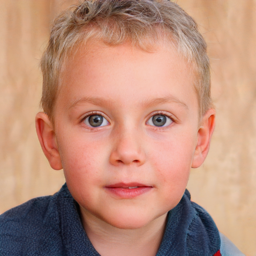

In [ ]:
num_imgs = 1
seed = np.random.randn(num_imgs,vector_size)
%time dlatent = Z2W(seed, Gs=Gs)#, psi=3, cut=18)
%time out_img = generate_images(dlatent,Gs=Gs)
show_images(out_img)

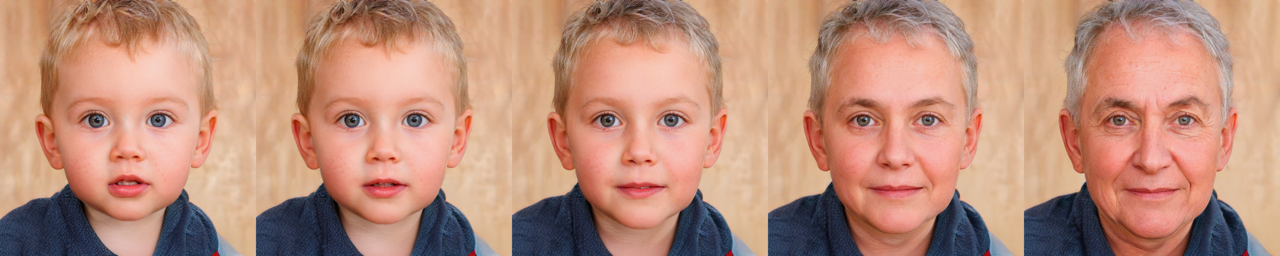

In [ ]:
direction = age #+gender*-1+smile*-0.5
lat_ver = interpolate_direction(dlatent, direction, scale=3)
out_img = generate_images(lat_ver,Gs=Gs)
show_images(out_img)

In [ ]:
cut = 8
new_latent_vector = lat.copy()
new_latent_vector[:,:cut] = ( lat 
    # + age * -10
    # + gender * -10
    + smile * 20
                           )[:,:cut]
out_img = generate_images(new_latent_vector)
show_images(out_img)

## More models

In [ ]:
url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
# url = "https://thisvesseldoesnotexist.s3-us-west-2.amazonaws.com/public/network-snapshot-008980.pkl"
_, _, Gs_blended = pretrained_networks.load_networks(url)

In [ ]:
seed = np.random.randn(1,vector_size)
seed = Z2W(seed, Gs=Gs_blended)
out_img = generate_images(seed, Gs_blended)
show_images(out_img)